---
# ***Task 1: Less than k***
---

Given a positive integer "k" and a list of integer numbers, look for the numbers within the list that are less than k. Consider an apropiate number of qubits and explain why your proposal is valid for all kind of number in case

##### Import the libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer import Aer
from qiskit.quantum_info import Operator, Statevector

##### Define all necessary functions

In [10]:
def decimal_labels(n_bits: int) -> list:
    """
    Generate a list of decimal labels based on the number of bits, 
    ranging from 0 to 2^n_bits

    Args:
        n_bits (int): Number of bits to represent
    Returns:
        decimal_labels (list): A list containing decimal labels as strings
    """

    decimal_labels = [str(x) for x in range(2**n_bits)]

    return decimal_labels

In [11]:
def oracle_matrix(n_qubits: int, k : int) -> np.ndarray:
    """
    Create an oracle matrix for Grover's algorithm. This matrix marks all 
    the number less than k

    Args:
        n_qubits (int): Number of qubits in the quantum system
        k (int): maximum number to mark
    Returns:
        oracle_matrix (np.ndarray): A matrix with the elements less than k 
            marked by a phase flip
    """
    oracle_matrix = np.identity(2**n_qubits)
    for i in range(k):
        oracle_matrix[i, i] = -1
    
    return oracle_matrix

In [38]:
def state_vector(n_qubits: int, number_list: list) -> np.ndarray:
    """
    Create an state vector for a quantum system which represents an equal superposition 
    between the unique elements in a number list

    Args:
        n_qubits (int): Number of qubits in the quantum system
        number_list (list): list of integers through which the search is performed
    Returns:
        state_vector (np.ndarray): A normalized state vector representing the numbers 
            in the list
    """
    state_vector = np.zeros(shape=(2**n_qubits))
    for number in number_list:
        state_vector[number] = 1.0

    norm = np.linalg.norm(state_vector)

    return state_vector/norm

In [40]:
def diffusion_matrix(n_qubits: int, phi: np.ndarray) -> np.ndarray:
    """
    Create a diffusion matrix for Grover's algorithm 

    Args:
        n_qubits (int): Number of qubits in the quantum system
        phi (np.ndarray): A normalized state vector representing the numbers 
            in the list through which the search is performed
    Returns:
        difussion_matrix (np.ndarray): An unitary matrix which represents the 
            diffusion operator
    """
    identity_matrix = np.identity(2**n_qubits)
    diffusion_matrix = 2*np.outer(phi, phi) - identity_matrix

    return  diffusion_matrix

In [104]:
def plot_amplitudes(circuit: QuantumCircuit, fig_size=(12, 8)) -> None:

    """
    Plots the amplitudes of the state vector of a given quantum circuit
    Args:
        circuit (QuantumCircuit): The quantum circuit for which to plot the amplitudes.

    Returns:
        None
    """

    state = np.array(Statevector(circuit))
    amplitudes = np.real(state)
    plt.figure(figsize=fig_size)
    plt.bar(decimal_labels(n_bits=circuit.num_qubits), amplitudes, color='#BE8AEE')
    plt.title('Amplitudes', fontsize=20)
    plt.xlabel('Basis state',fontsize=13)
    plt.ylabel('Amplitudes', fontsize=13)
    plt.xticks(rotation='vertical')
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.show()

### **Quantum Circuit Initialization**
---

The Quantum Circuit is initialized with an equal superposition between the unique elements in the list. This initialization requires the number list contain only numbers less than $2^\text{\#qubits}$ where #qubits is the number of qubits in the quantum circuit. The list also has to contain only non-negative numbers, for an implementation which support negative numbers it is possible to use an auxiliar qubit whose value represents the sign of the number.

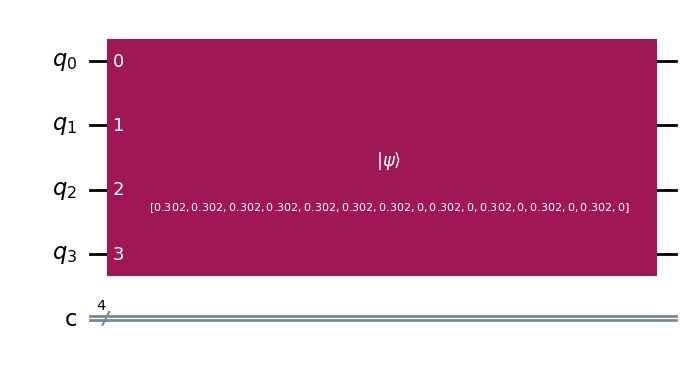

In [83]:
# define the number of qubits in the circuit
n_qubits = 4

# Define the number k
k = 4

# Crete an list with random integers ranging from 0 to 2^n_qubits
number_list = [np.random.randint(0, 2**n_qubits) for _ in range(20)]

# Create a circuit in equal superposition between the unique elements in number_list
state_vec = state_vector(n_qubits=n_qubits, number_list=number_list)
circuit = QuantumCircuit(n_qubits, n_qubits)
circuit.initialize(state_vec,range(n_qubits))

circuit.draw('mpl')


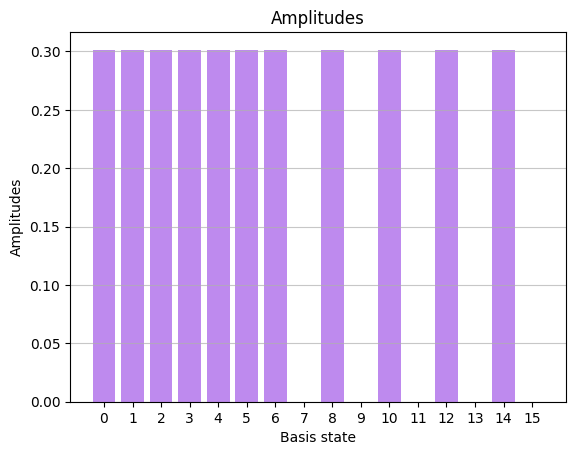

In [84]:
# Plot the amplitudes 
plot_amplitudes(circuit)

The result is a quantum circuit in equal superposition of the states in the list

### ***Grover's Algorithm Implementation***
---

The Grover's Algorithm implementation consist in the implementation of two separated operators: *Oracle operator* and *Diffusion operator*.

##### ***Oracle Operator***

Once the quantum circuit has been initialized, an oracle operator is applied, its function is to mark the desired elements by a phase flip, in our case, the oracle phase flips all the numbers less than the given integer $k$

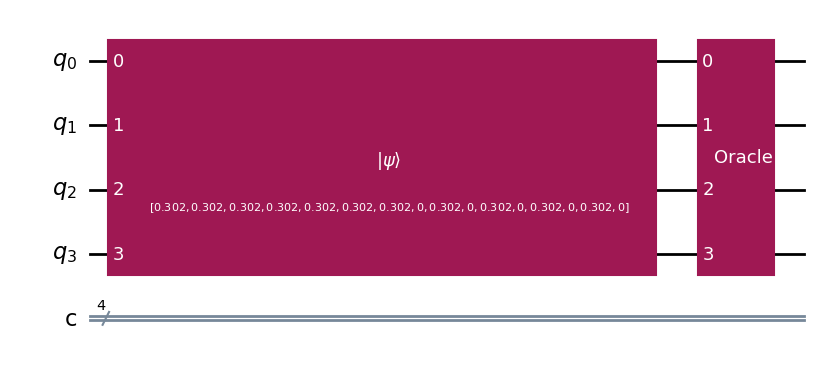

In [85]:
# Apply the oracle to the circuit
U = Operator(oracle_matrix(n_qubits=n_qubits, k=k))
circuit.unitary(U, range(n_qubits), label='Oracle')

circuit.draw('mpl')

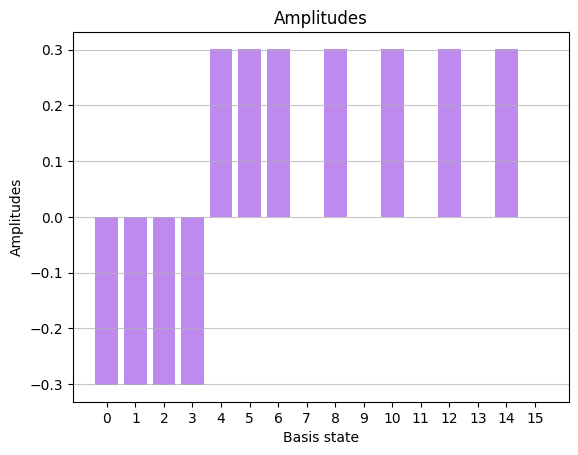

In [86]:
# Plot the amplitudes of the quantum system
plot_amplitudes(circuit)


The result is a phase flip of the desired quantum states

##### ***Diffusion Operator***

When the oracle has been applied and the desired elements has been marked, we need to increase their amplitude while decreasing the amplitude of the remaining elements, this is done by the diffusion operator.

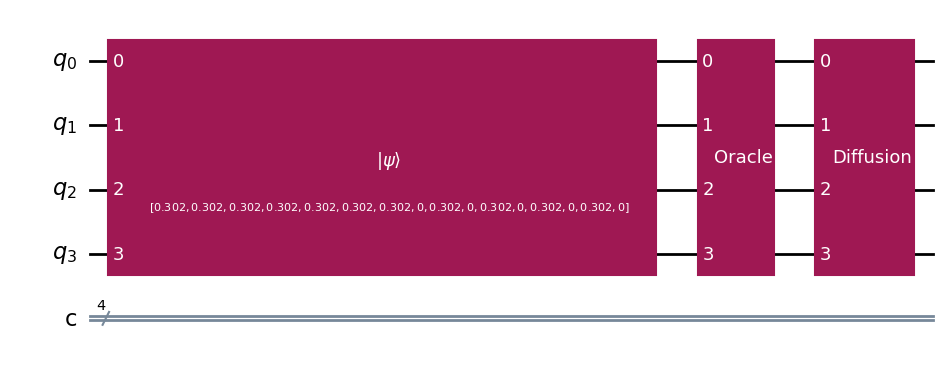

In [87]:
# Apply the oracle to the circuit
D = Operator(diffusion_matrix(n_qubits=n_qubits, phi=state_vec))
circuit.unitary(D, range(n_qubits), label='Diffusion')

circuit.draw('mpl')

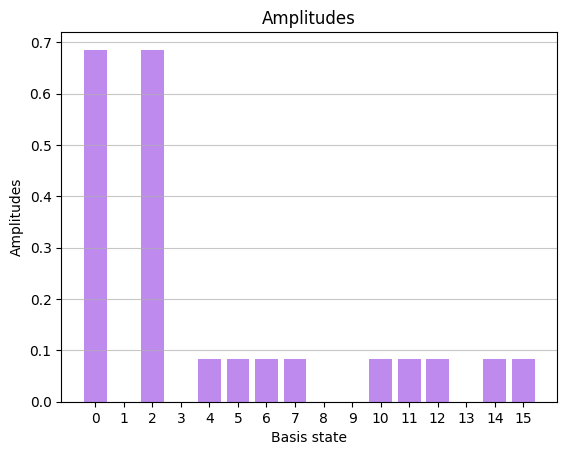

In [79]:
plot_amplitudes(circuit)

The result is an amplitude increment for the marked states along with an amplitude decrement for the remaining states

### ***Grover's Algorithm Application***
---

Once implemented, lets complete the task by applying Grover's Algorithm to find all the numbers less than a given integer $k$ within a list. First we need to define the *Grover's Operator* which is composed by the oracle operator followed by the diffusion operator.

$$
G = DU_{f}
$$

This operator has to be applied iteratively, and the number of iteration depends on the total number of unique elements in the list $(N)$ and the number of elements satisfying the condition $(m)$. In a real life problem, the number of elements $N$ is greater than $m$, otherway, looking for elements satisfying a condition within a list where most of the elements satisfy this condition does not make sense. In such case the number of steps needed for an optimal result is 

$$
S \approx \frac{\pi}{4}\sqrt{\frac{N}{m}}
$$

In our case, we can not always know the number of unique elements nor the number of elements satisfying the condition in the list. Nevertheless for a list of integers large enough this number can be approximated by 

$$N = 2^{n} \\
m = k$$

where $n$ is the number of qubits in the circuit.

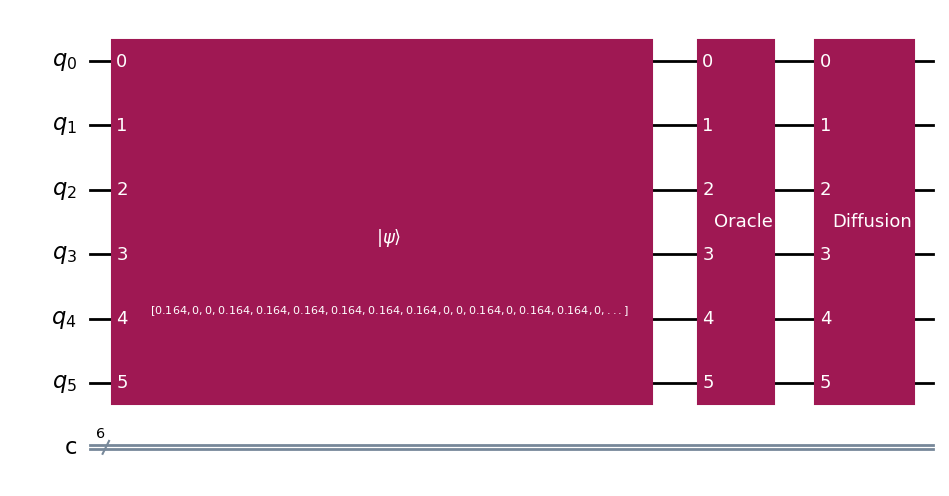

In [227]:
# define the number of qubits in the circuit
n_qubits = 6

# Define the number k
k = 14

# Crete an list with random integers ranging from 0 to 2^n_qubits
number_list = [np.random.randint(0, 2**n_qubits) for _ in range(50)]

# Create a circuit in equal superposition between the unique elements in number_list
state_vec = state_vector(n_qubits=n_qubits, number_list=number_list)
circuit = QuantumCircuit(n_qubits, n_qubits)
circuit.initialize(state_vec,range(n_qubits))

U = Operator(oracle_matrix(n_qubits=n_qubits, k=k))
D = Operator(diffusion_matrix(n_qubits=n_qubits, phi=state_vec))

# Apply the grover's operator
n_steps = np.pi/4*np.sqrt((2**n_qubits)/k)
for step in range(int(n_steps)):
    circuit.unitary(U, range(n_qubits), label='Oracle')
    circuit.unitary(D, range(n_qubits), label='Diffusion')

circuit.draw('mpl')

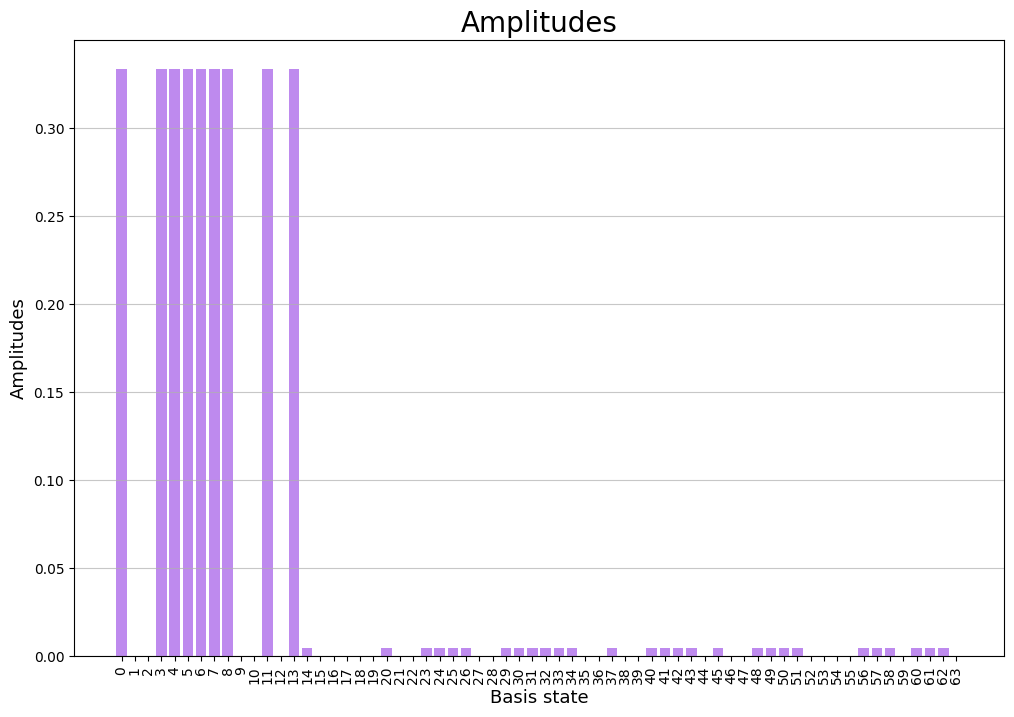

In [228]:
plot_amplitudes(circuit)

After the optimal number of steps, the amplitudes of the solution states are much greater than the amplitudes of the non-solution states. Just as we wanted.

### ***Results and further work***
---

#### ***Function***

In [226]:
def less_than_k(k: int, number_list: list) -> list:
    """ Returns the number within a number list that are less than a given number k

    Args:
        k (int): integer value that is the positive number to compare in number_list
        number_list (list): integer list that has positive numbers

    Return:
        A list with the numbers in the number_list that are less than k   
    """
    
    
    # define the number of qubits in the circuit
    maximum = np.max(number_list)
    n_qubits = int(np.ceil(np.log2(maximum)))

    # Create a circuit in equal superposition between the unique elements in number_list
    state_vec = state_vector(n_qubits=n_qubits, number_list=number_list)
    circuit = QuantumCircuit(n_qubits, n_qubits)
    circuit.initialize(state_vec,range(n_qubits))

    U = Operator(oracle_matrix(n_qubits=n_qubits, k=k))
    D = Operator(diffusion_matrix(n_qubits=n_qubits, phi=state_vec))

    # Apply the grover's operator
    n_steps = np.pi/4*np.sqrt((2**n_qubits)/k)
    for step in range(int(n_steps)):
        circuit.unitary(U, range(n_qubits), label='Oracle')
        circuit.unitary(D, range(n_qubits), label='Diffusion')

    # find the solutions
    state = np.array(Statevector(circuit))
    solution_amp = np.max(state)

    return np.where(np.isclose(state, solution_amp, atol=0.01))[0]


A = less_than_k (7,[4,9,11,14,1,13,6,15])
print(A)


[1 4 6]


The algorithm implemented above has proven work for the specified cases. It increases the amplitude of the states representing numbers smaller tha $k$ and decreases the amplitude of states representing numbers grater than k within a list of numbers. Nevertheless this implementation does not tells us how many elements in the list satisfy the condition, it just tells us the unique elements in the list that satisfy the condition. The implementation also has the limitaion of negative integers, this two limitations can be tackled in future improvements of this implementation.